In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
# create new folders
!mkdir TRAIN2 TEST2 VAL2 TRAIN2/YES TRAIN2/NO TEST2/YES TEST2/NO VAL2/YES VAL2/NO
!tree -d

In [ ]:
IMG_PATH = '/content/drive/MyDrive/Projeto/Brain_Tumor/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.1*IMG_NUM:
                shutil.copy(img, 'TEST2/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN2/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL2/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/TRAIN2'
test_path = '/content/TEST2'
valid_path = '/content/VAL2'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 224x224
img_height = 224
img_width = 224
#The dimension size of 500 or more than 500 with batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. A lower dimension size with greater batch size is one of the options to try.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 2100 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


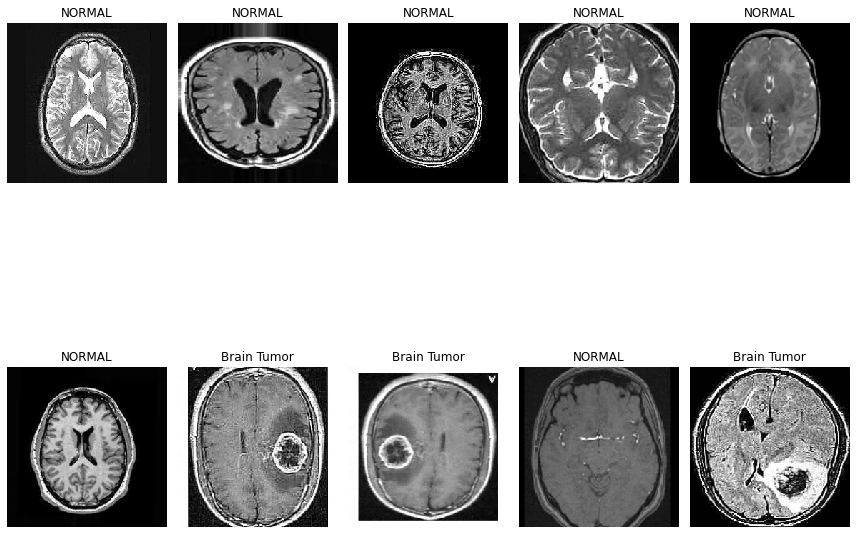

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'Brain Tumor'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [ ]:
filters=32
height=500
width=500
colorchannel=1
kernel_size=(3,3)


# Hyperparameters of Conv2D
Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    activation=None,
    input_shape=(height,width,colorchannel)
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding='valid'
    )

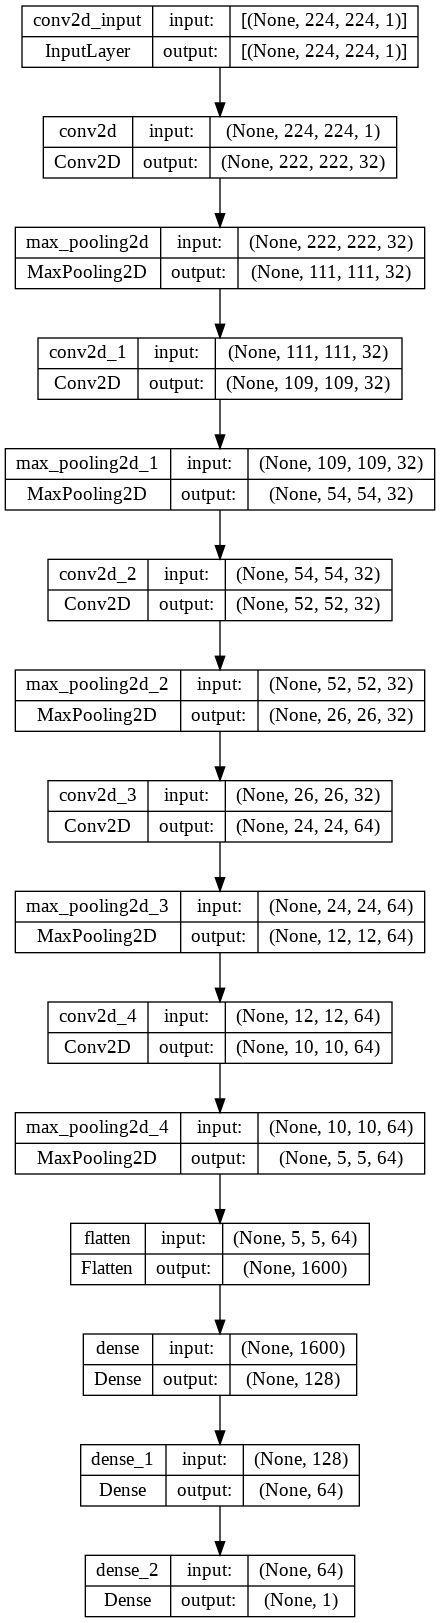

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [ ]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight ("balanced", classes = np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0, 1: 1.0}


In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
132/132 [==============================] - 146s 1s/step - loss: 0.5801 - accuracy: 0.6962 - val_loss: 0.5439 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 2/25
132/132 [==============================] - 137s 1s/step - loss: 0.4765 - accuracy: 0.7729 - val_loss: 0.4519 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 3/25
132/132 [==============================] - 137s 1s/step - loss: 0.3634 - accuracy: 0.8419 - val_loss: 0.4249 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 4/25
132/132 [==============================] - 135s 1s/step - loss: 0.3303 - accuracy: 0.8624 - val_loss: 0.4153 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 5/25
132/132 [==============================] - 134s 1s/step - loss: 0.2652 - accuracy: 0.8933 - val_loss: 0.3200 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 6/25
132/132 [==============================] - 129s 974ms/step - loss: 0.2218 - accuracy: 0.9114 - val_loss: 0.3875 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 7/25
132/132 [==============================] - 128s 96

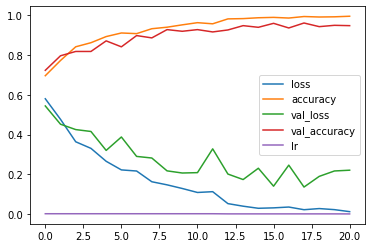

In [ ]:
pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

19/19 [==============================] - 4s 217ms/step - loss: 0.1857 - accuracy: 0.9667
The testing accuracy is : 96.66666388511658 %


In [ ]:
preds = cnn.predict(test,verbose=1)

19/19 [==============================] - 4s 218ms/step


In [ ]:
preds

array([[2.87739094e-04],
       [1.77440242e-07],
       [9.99446836e-09],
       [3.68029021e-08],
       [6.16543927e-09],
       [1.84282399e-04],
       [4.15294409e-07],
       [8.54527752e-05],
       [1.08504274e-07],
       [1.36189637e-05],
       [2.44057956e-05],
       [7.62931563e-07],
       [2.78024876e-04],
       [4.77879869e-09],
       [3.76926934e-08],
       [2.58140010e-03],
       [2.34784745e-03],
       [7.84974252e-10],
       [6.99864486e-08],
       [6.70453417e-08],
       [4.48226501e-07],
       [2.09079869e-03],
       [7.37695771e-08],
       [2.01341547e-02],
       [1.34346623e-03],
       [3.66482660e-02],
       [5.24198285e-08],
       [6.33888430e-06],
       [1.52780657e-07],
       [6.28013538e-07],
       [1.86099749e-06],
       [4.65848076e-04],
       [1.99384587e-07],
       [1.34420316e-05],
       [3.28161718e-07],
       [6.18773186e-07],
       [5.66764676e-04],
       [3.97419179e-04],
       [8.88699142e-05],
       [6.83328096e-07],


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

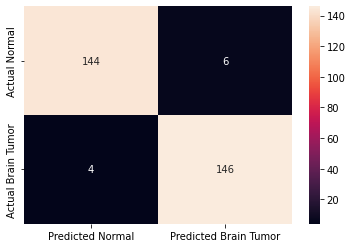

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Brain Tumor"],
columns=["Predicted Normal", "Predicted Brain Tumor"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','BRAIN TUMOR']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.96      0.97       150
 BRAIN TUMOR       0.96      0.97      0.97       150

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



(300, 224, 224, 1)
(300,)


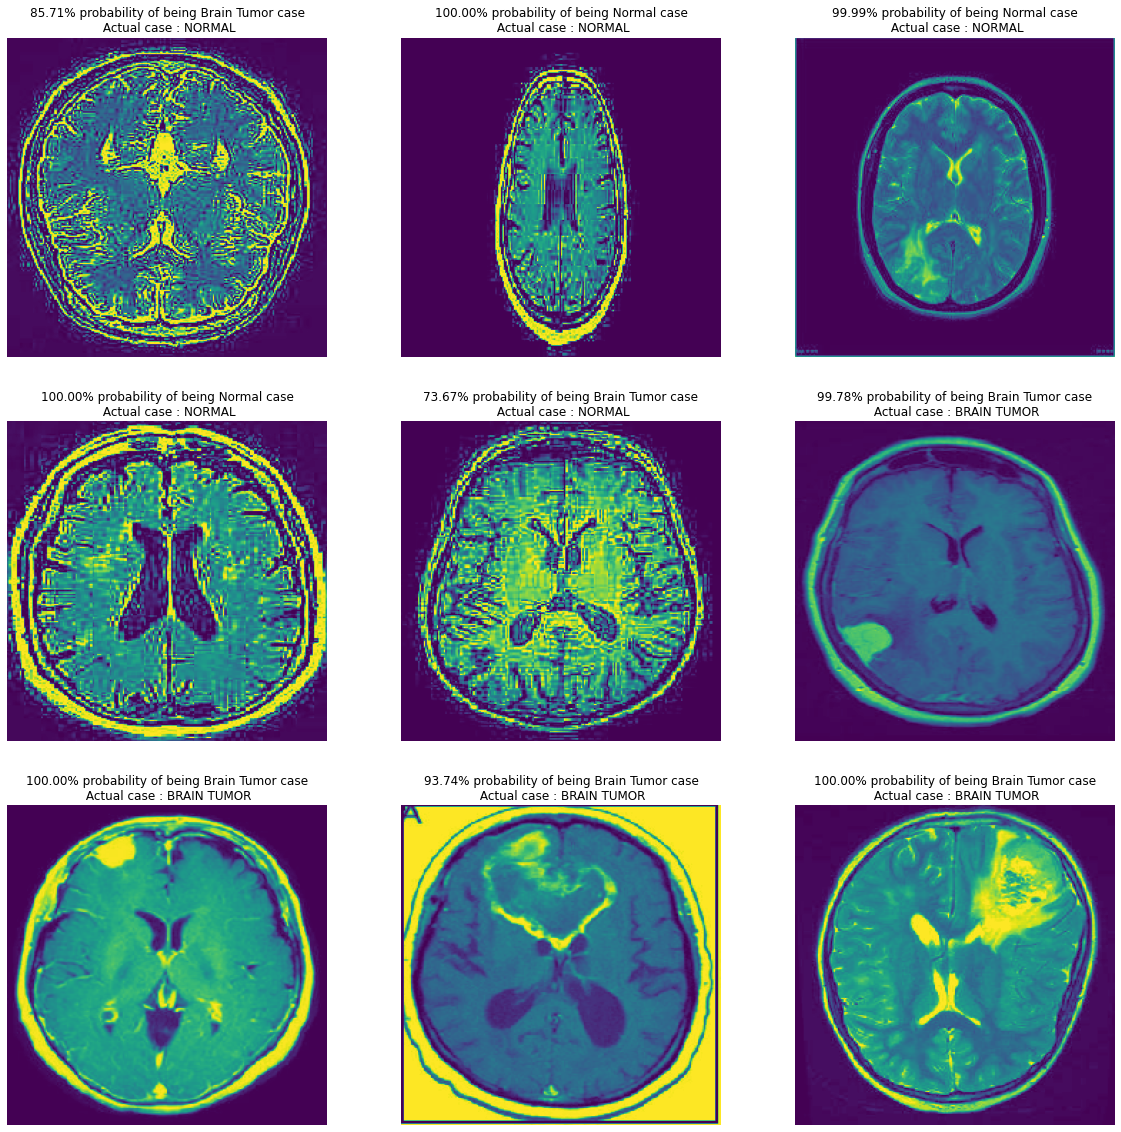

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
sorted(preds, key = lambda x: float(x[0]))
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'BRAIN TUMOR'}
plt.figure(figsize=(20,20))
for i in range(145, 154):
  plt.subplot(3, 3, (i-145)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Brain Tumor case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [ ]:
!pip install pipreqs

!pipreqs /content/drive/MyDrive/Projeto/Brain_Tumor/ --force

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
INFO: Successfully saved requirements file in /content/drive/MyDrive/Projeto/Brain_Tumor/requirements.txt
